In [1]:
import os
import lumpyrem as lr # cloned from github (pip package does not yet support lr2)
from shutil import copyfile

Setup directories:

In [2]:
bins_pth = os.path.join('..', 'bins', 'win') if 'nt' in os.name else os.path.join('..', 'bins', 'linux') # Binaries

lumprem_input_pth = os.path.join('..', 'data', 'lumprem_input') # Input data curated in a previous notebook

workspace = os.path.join('..', 'hagfors_lumprem_prep') # Workspace where model will be stored

Create workspace:

In [3]:
if not os.path.exists(workspace):
    os.mkdir(workspace)

Copy input-data to workspace:

In [4]:
os.listdir(lumprem_input_pth)

['evapot.dat', 'rainfall.dat']

In [5]:
for file in os.listdir(lumprem_input_pth):
    copyfile(lumprem_input_pth+'\\'+file, workspace+'\\'+file) #Works for Windows. Does it work for Linux?

In [6]:
os.listdir(workspace)

['evapot.dat', 'lumprem.exe', 'lumprep.exe', 'rainfall.dat']

## Setup LUMPREM and run model

### Create rch and evt:

In [7]:
# initiate the model and write the in files. What about rbuf & mbuf?
rch_evap = lr.lumprem.Model(
    model_name ='hagfors',
    workspace = workspace,
    irrigvolfrac = 0.0,
    rainfile = 'rainfall.dat',
    epotfile = 'evapot.dat',
    maxvol = 0.2, # Varför valde jag 0.2 istället för 0.5 som är default?
    vol = 0.1,
    ks = 43.2 # 43.2 m/day = 0.0005 m/s ≈ reasonable initial guess considering local geology
)

In [8]:
# For some reason this results in 1461 rather than 1462 rows. Will this cause a problem?
rch_evap.write_model(
    start_date = '01/01/2016',
    end_date = '01/01/2020',
    nstep = 4,
    mxiter = 500,
)

LUMPREM model input file written to: 
..\hagfors_lumprem_prep\lr_hagfors.in
PEST template file written to: 
..\hagfors_lumprem_prep\lr_hagfors.tpl



In [9]:
# run themodel
rch_evap.run_model(version=2)

 Enter name of LUMPREM input file:  Enter name for LUMPREM tabular output file:  Enter name for CSV output file (<Enter> if none):  
 - file lr_hagfors.in read ok.
 - file lumprem_variables.rec written ok.
 - file rainfall.dat read ok.
 - file evapot.dat read ok.
 RECHMOD upper bucket: call   1 day   1 step   1: iteration limit exceeded
 RECHMOD upper bucket: call   1 day   1 step   2: iteration limit exceeded
 RECHMOD upper bucket: call   1 day   1 step   3: iteration limit exceeded
 - file lr_hagfors.out written ok.
 - file lr_hagfors.csv written ok.



In [10]:
# get model results
results = rch_evap.get_results()
results.columns

Index(['days', 'vol_upper', 'vol_lower', 'vol_drain', 'vol_macro',
       'del_vol_upper', 'del_vol_lower', 'del_vol_drain', 'del_vol_macro',
       'rainfall', 'irrigation', 'drain_upper', 'macro_upper', 'drain_lower',
       'overflow_lower', 'total_rech', 'gw_withdrawal', 'net_recharge',
       'runoff', 'pot_evap_upper', 'evap_upper', 'pot_evap_lower',
       'evap_lower', 'gw_pot_evap', 'balance', 'elevation', 'depth-to-water',
       'lumprem_model_name', 'rainfile', 'epotfile', 'vegfile', 'irrigfile',
       'maxvol', 'irrigvolfrac', 'rdelay', 'mdelay', 'ks', 'M', 'L',
       'mflowmax', 'offset', 'factor1', 'factor2', 'power', 'elevmin',
       'elevmax', 'surface', 'vol', 'workspace', 'maxvol_br', 'extravol_br',
       'gamma_br', 'ks_br', 'm_br', 'l_br', 'vol_br', 'epotfile_br',
       'epot_br_all'],
      dtype='object')

In [11]:
results.head()

,days,vol_upper,vol_lower,vol_drain,vol_macro,del_vol_upper,del_vol_lower,del_vol_drain,del_vol_macro,rainfall,...,workspace,maxvol_br,extravol_br,gamma_br,ks_br,m_br,l_br,vol_br,epotfile_br,epot_br_all
0,0,0.100000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0000,...,..\hagfors_lumprem_prep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14,0.025464,0.0,0.007949,0.0,-0.074536,0.0,0.007949,0.0,0.0134,...,..\hagfors_lumprem_prep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29,0.031558,0.0,0.008485,0.0,0.006094,0.0,0.000535,0.0,0.0204,...,..\hagfors_lumprem_prep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,43,0.028511,0.0,0.010384,0.0,-0.003048,0.0,0.001899,0.0,0.0253,...,..\hagfors_lumprem_prep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,58,0.021387,0.0,0.003143,0.0,-0.007123,0.0,-0.007241,0.0,0.0061,...,..\hagfors_lumprem_prep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='days'>

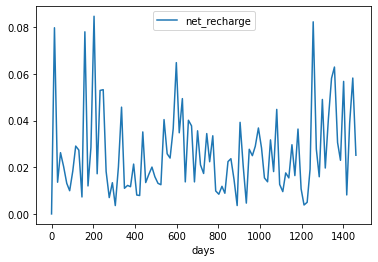

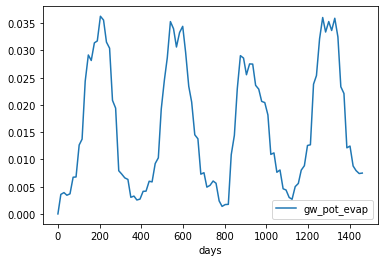

In [12]:
results.plot('days','net_recharge')
results.plot('days', 'gw_pot_evap')

### Create CHD timeseries:

In [13]:
ghb = lr.lumprem.Model(
    'ghb',
    workspace=workspace,
    factor1=30,
    factor2=20,
    power=2,
    offset=136.0,
    maxvol=0.5,
    vol = 0.07,
    surface=152.2,
    elevmin = -9999.0,
    elevmax = 9999.0,
    ks=43.2,
    irrigvolfrac=0.0,
    vegfile=(0.8,1.0),
    rainfile = 'rainfall.dat',
    epotfile = 'evapot.dat',
    irrigfile = (0, 0.0)
)

In [14]:
ghb.write_model(
    start_date = '01/01/2016',
    end_date = '01/01/2020',
    nstep = 4,
    mxiter = 500,
)
ghb.run_model(version=2)
df=ghb.get_results()

LUMPREM model input file written to: 
..\hagfors_lumprem_prep\lr_ghb.in
PEST template file written to: 
..\hagfors_lumprem_prep\lr_ghb.tpl

 Enter name of LUMPREM input file:  Enter name for LUMPREM tabular output file:  Enter name for CSV output file (<Enter> if none):  
 - file lr_ghb.in read ok.
 - file lumprem_variables.rec written ok.
 - file rainfall.dat read ok.
 - file evapot.dat read ok.
 - file lr_ghb.out written ok.
 - file lr_ghb.csv written ok.



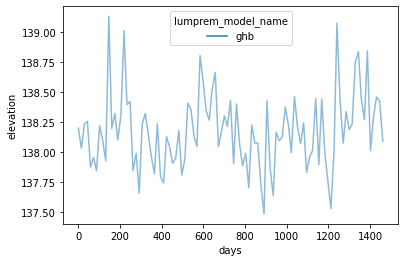

In [15]:
# plot the model results
import seaborn as sb
sb.lineplot(data=df, x='days',y='elevation', hue='lumprem_model_name', alpha=0.5);

## Use LR2SERIES to generate MODFLOW6 timeseries files from LUMPREM model outputs

In [16]:
# use LR2SERIES to create the ts file
rch_ts = lr.lr2series.TimeSeries(
    ts_file='rch.ts',
    workspace=workspace,
    lr_models=[rch_evap],
    ts_names=['rch'],
    lumprem_output_cols=['net_recharge'],
    methods=['linearend'],
    div_delta_t=True
)

rch_ts.write_ts()

MF6 timeseries file ..\hagfors_lumprem_prep\rch.ts.in written to:
..\hagfors_lumprem_prep\rch.ts.in
 Enter name of LR2SERIES control file:  
 - reading file rch.ts.in...
 
 - reading LUMPREM output file lr_hagfors.out...
 - file lr_hagfors.out read ok.
 - writing file rch.ts...
 - file rch.ts written ok.
 
 - file rch.ts.in read ok.



In [17]:
# use LR2SERIES to create the ts file
evp_ts = lr.lr2series.TimeSeries(
    ts_file='evp.ts',
    workspace=workspace,
    lr_models=[rch_evap],
    ts_names=['evp'],
    lumprem_output_cols=['gw_pot_evap'],
    methods=['linearend'],
    div_delta_t=True
)

evp_ts.write_ts()

MF6 timeseries file ..\hagfors_lumprem_prep\evp.ts.in written to:
..\hagfors_lumprem_prep\evp.ts.in
 Enter name of LR2SERIES control file:  
 - reading file evp.ts.in...
 
 - reading LUMPREM output file lr_hagfors.out...
 - file lr_hagfors.out read ok.
 - writing file evp.ts...
 - file evp.ts written ok.
 
 - file evp.ts.in read ok.



In [18]:
# use LR2SERIES to create the ts file
ghb_ts = lr.lr2series.TimeSeries(
    ts_file='ghb.ts',
    workspace=workspace,
    lr_models=[ghb],
    ts_names=['evp'],
    lumprem_output_cols=['gw_pot_evap'],
    methods=['linearend'],
    div_delta_t=True
)

evp_ts.write_ts()

MF6 timeseries file ..\hagfors_lumprem_prep\evp.ts.in written to:
..\hagfors_lumprem_prep\evp.ts.in
 Enter name of LR2SERIES control file:  
 - reading file evp.ts.in...
 
 - reading LUMPREM output file lr_hagfors.out...
 - file lr_hagfors.out read ok.
 - writing file evp.ts...
 - file evp.ts written ok.
 
 - file evp.ts.in read ok.



In [19]:
os.listdir(workspace)

['evapot.dat',
 'evp.ts',
 'evp.ts.in',
 'lr_ghb.csv',
 'lr_ghb.in',
 'lr_ghb.out',
 'lr_ghb.tpl',
 'lr_hagfors.csv',
 'lr_hagfors.in',
 'lr_hagfors.out',
 'lr_hagfors.tpl',
 'lumprem.exe',
 'lumprem_variables.rec',
 'lumprep.exe',
 'rainfall.dat',
 'rch.ts',
 'rch.ts.in']